In [111]:
!pip install beautifulsoup4
!pip install lxml
!pip install html5lib
!pip install wordcloud

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib
from bs4 import BeautifulSoup
import datetime
import ast
import csv
from IPython.display import HTML

from urllib.error import HTTPError

from wordcloud import WordCloud
import bs4
from bs4 import BeautifulSoup
import json

In [112]:
coursera_urls = ['https://www.coursera.org/search?query=data%20science&index=prod_all_products_term_optimization&entityTypeDescription=Courses&allLanguages=English', 
          'https://www.coursera.org/search?query=data%20science&page=2&index=prod_all_products_term_optimization&entityTypeDescription=Courses&allLanguages=English']
url = urllib.request.urlopen(coursera_urls[0])
content = url.read()
soup = BeautifulSoup(content, 'lxml')

In [113]:
MAXIMUM_PAGE_NUM = 100
course_count = 0
for i in range(MAXIMUM_PAGE_NUM):
  if i<=1:
    cur_url = coursera_urls[i]
  # generate url with new page num
  if(i>1):
    and_index = cur_url.find('&')
    second_index = and_index
    first_index = second_index
    while(i < len(cur_url)):
      second_index = second_index + 1
      if(cur_url[second_index]=='&'):
        updated_page = "&page=" + str(i+1)
        cur_url = cur_url[0:first_index] + updated_page + cur_url[second_index:]
        coursera_urls.append(cur_url)
        break

In [ ]:
column_names = ["Course", "URL", "KeyWords"]
df_course_keywords = pd.DataFrame(columns = column_names)
course_count = 0
for url_id in range(len(coursera_urls)):
  print("{}".format(coursera_urls[url_id]))
  url = urllib.request.urlopen(coursera_urls[url_id])
  content = url.read()
  soup = BeautifulSoup(content, 'lxml')
  
  course_urls = []
  course_names = []
  for scriptTag in soup.find_all('script',{'type': 'application/ld+json'}):
    script_content = json.loads(scriptTag.text)
    print("content: {}".format(script_content))
    for i in range( len(script_content['itemListElement']) ):
      cur_url = script_content['itemListElement'][i]['url']
      slash_index = cur_url.rfind('/')
      cur_name = cur_url[slash_index+1:]
      cur_name = cur_name.replace("/", " ")

      course_names.append(cur_name)
      course_urls.append(cur_url)
      df_course_keywords.at[course_count, 'Course'] = cur_name
      df_course_keywords.at[course_count, 'URL'] = cur_url
      print("cur_name: {}".format(cur_name))
      print("cur_url: {}".format(cur_url))
      # obtain skills for this course
      try:
        url = urllib.request.urlopen(cur_url)
        content = url.read()
        soup = BeautifulSoup(content, 'lxml')
        skills = []
        for tag in soup.find_all('span',{'class': '_1q9sh65'}):
          skills.append(tag.text)
        df_course_keywords.at[course_count, 'KeyWords'] = skills
        print('cur_skills: {}'.format(skills))
        course_count = course_count + 1
      except:
        print("An error occured.")

In [206]:
# process the KeyWords column
for i in range( len(df_course_keywords.index) ):
  cur_key_word = df_course_keywords.iloc[i]['KeyWords']
  cur_key_word = cur_key_word.replace(", ", ",")
  cur_key_word = cur_key_word.replace("'", "")
  cur_key_word = cur_key_word.replace("[", "")
  cur_key_word = cur_key_word.replace("]", "")
  cur_key_word = cur_key_word.split(",")
  df_course_keywords.at[i, 'KeyWords'] = cur_key_word

In [214]:
df_course_keywords['Skills'] = df_course_keywords['KeyWords']
df_course_keywords.drop(columns=['KeyWords'], inplace=True)

In [215]:
df_course_keywords.to_csv('df_course_skills.csv', index=False)

In [216]:
df_course_keywords.head()

,Course,URL,Skills
0,ibm-data-science,https://www.coursera.org/professional-certific...,"[Data Science, Statistical Analysis, Machine L..."
1,jhu-data-science,https://www.coursera.org/specializations/jhu-d...,"[Github, Machine Learning, R Programming, Regr..."
2,data-science-python,https://www.coursera.org/specializations/data-...,"[Text Mining, Python Programming, Pandas, Matp..."
3,introduction-data-science,https://www.coursera.org/specializations/intro...,"[Data Science, Relational Database Management ..."
4,data-science-foundations-r,https://www.coursera.org/specializations/data-...,"[Data Science, Machine Learning, Github, R Pro..."


Count key words frequency

In [217]:
column_names = ["Skills", "Count"]
df_keywords_count = pd.DataFrame(columns = column_names)
df_keywords_count['Count'] = 0

In [ ]:
cur_count = 0
for i in range( len(df_course_keywords.index) ):
  print("i: {}".format(i))
  cur_key_word = df_course_keywords.iloc[i]['Skills']
  for j in range( len(cur_key_word) ):
    cur_word = cur_key_word[j].lower()
    if len(cur_word) == 0:
      continue
    match = ( df_keywords_count['Skills']==cur_word ) 
    match_unique = match.unique()
    if ( len(match_unique) == 0 or len(match_unique) == 1 ):
      df_keywords_count.at[cur_count, 'Skills'] = cur_word
      df_keywords_count.at[cur_count, 'Count'] = 0
      cur_count  = cur_count + 1
      #input("==1 say something...")
    else:
      for t_f_id in range( len(match) ):
        if match[t_f_id]==True:
          df_keywords_count.at[t_f_id, 'Count'] = df_keywords_count.at[t_f_id, 'Count'] + 1
          break
      #input("!=1 say something...")

In [220]:
result = df_keywords_count.sort_values(by=['Count'], ascending=False)
result.to_csv('coursera_skills_sort.csv', index=False)

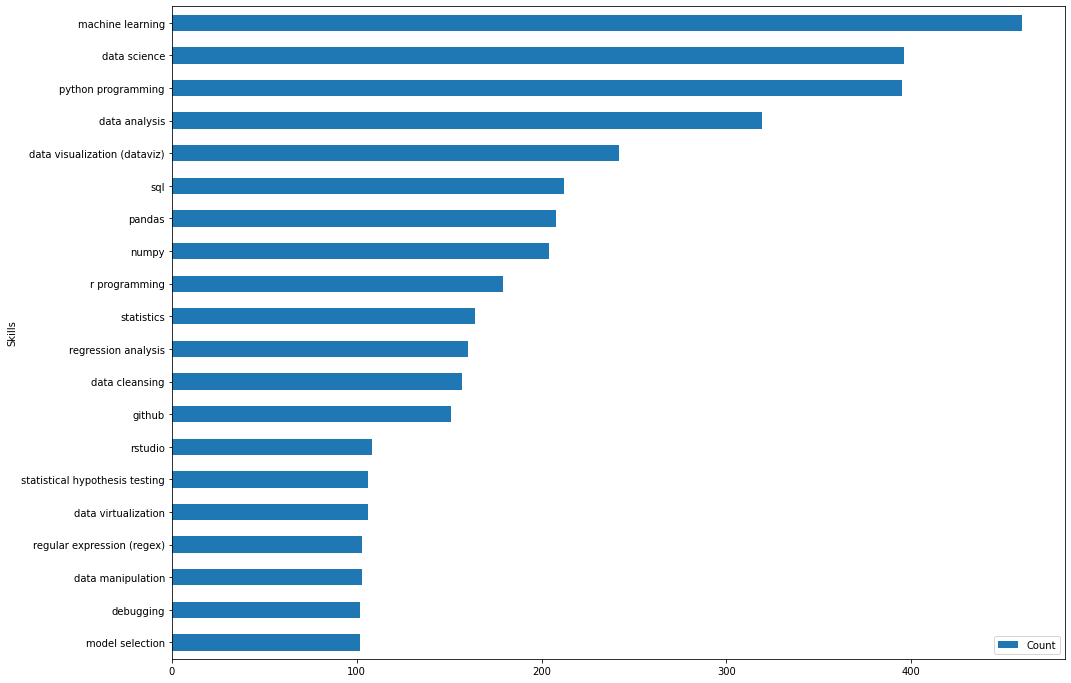

In [225]:
ax = result[0:20].plot.barh(x='Skills', y='Count', rot=0, figsize=(16,12))
ax.invert_yaxis()